In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join, exists, basename, dirname

import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [17]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = join(gwfm_dir, 'Oneto_Denier')
dat_dir = join(proj_dir,'Stream_level_data')
map_dir = join(gwfm_dir,'Mapping')

sfr_dir = join(gwfm_dir,'SFR_data')
hob_dir = join(gwfm_dir,'HOB_data')

In [21]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



In [5]:
rivers = gpd.read_file(join(sfr_dir,"Sac_valley_rivers/Sac_valley_rivers.shp"))
rivers = rivers.to_crs('EPSG:32610')

mb_regional = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
# mb = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
rivers_clip = gpd.clip(rivers, mb_regional)

soam = gpd.read_file(join(map_dir,"so_am_subbasin/so_am_subbasin.shp"))
soam = soam.to_crs('EPSG:32610')
cos = gpd.read_file(join(map_dir,"cos_subbasin/cos_subbasin.shp"))
cos = cos.to_crs('EPSG:32610')

ca = gpd.read_file(join(map_dir,"ca_state_boundary/CA_State_TIGER2016.shp"))
ca = ca.to_crs('EPSG:32610')

In [10]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'

In [14]:
grid_p['id'] = 0
m_domain = grid_p.dissolve('id')

In [18]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']


In [7]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
# ifp = gpd.read_file(join(lak_shp,'inner_floodplain_domain/inner_floodplain_domain.shp' )).to_crs('epsg:32610')
# lfp = gpd.read_file(join(lak_shp,'lower_floodplain_approximate_area/lower_floodplain_approximate_area.shp' )).to_crs('epsg:32610')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')

fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
# fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',op='within')

In [8]:
od_breach = fp_logger[fp_logger['Logger Location']=='OD_Excavation']
od_swale = fp_logger[fp_logger['Logger Location']=='SwaleBreach_1']

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_134492\3433821054.py:36: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


<AxesHostAxes: >

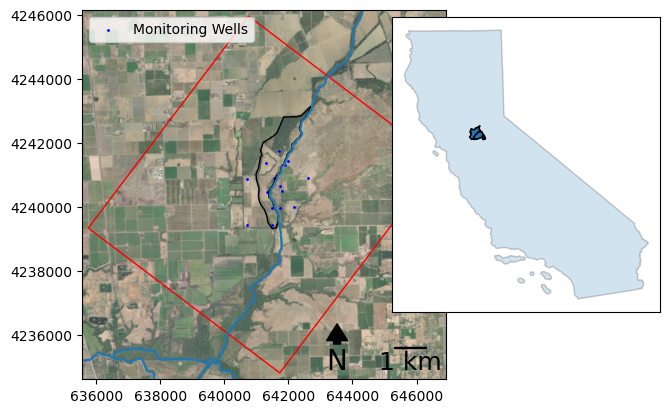

In [31]:
fig,ax=plt.subplots()
gdf_bnds(m_domain,ax=ax, buf=200)

# od_breach.plot(ax=ax)
# od_swale.plot(ax=ax)

rivers_clip.plot(ax=ax)
m_domain.plot(color="none",edgecolor='red',ax=ax, label='Model Bounds')
rm_t.plot(legend=False,ax=ax, color='blue', markersize=1, label='Monitoring Wells')

lak_extent.plot(ax=ax, color='none', label='Reconnected Floodplain')

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

x, y, arrow_length = 0.7, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

ax.ticklabel_format(style='plain')


fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           sep=2,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

ax.legend(loc='upper left')
# plt.xlabel('Easting (m)')
# plt.ylabel('Northing (m)')


# first one is CA map
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.8, .2, .8, .8),
                  bbox_transform=ax.transAxes, loc=2)
# second one is smaller inset
# axins2 = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.18, .5, .5, .5),
#                   bbox_transform=ax.transAxes, loc=2)
axins.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)
# axins2.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

ca.plot(ax = axins,alpha = 0.2, edgecolor='black')
# ca.plot(ax = axins,alpha = 0.2)
soam.plot(ax = axins, edgecolor = 'black')
cos.plot(ax = axins, edgecolor = 'black')

# rect, connectors = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5, transform=ax.transAxes)

# cos.plot(ax = axins2, edgecolor = 'black')
# soam.plot(ax = axins2, edgecolor = 'black')
# teichert.plot(ax = axins2, edgecolor = 'black', color = 'none')

In [44]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


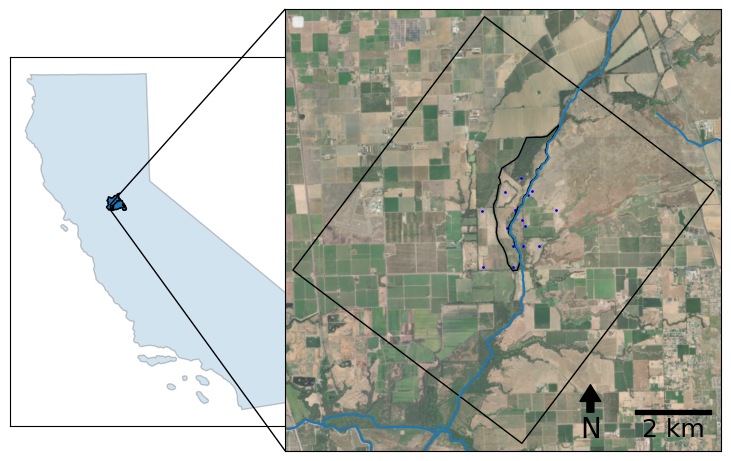

In [70]:
fig, axins =plt.subplots()


# second one is smaller inset
# axins2 = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.18, .5, .5, .5),
#                   bbox_transform=ax.transAxes, loc=2)
axins.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)
# axins2.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

ca.plot(ax = axins,alpha = 0.2, edgecolor='black')
soam.plot(ax = axins, edgecolor = 'black')
cos.plot(ax = axins, edgecolor = 'black')

# rect, connectors = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5, transform=ax.transAxes)

# cos.plot(ax = axins2, edgecolor = 'black')
# soam.plot(ax = axins2, edgecolor = 'black')
# teichert.plot(ax = axins2, edgecolor = 'black', color = 'none')

# first one is CA map
ax = inset_axes(axins, width="100%", height="100%", bbox_to_anchor=(0.8, -.1, 1.3, 1.3),
                  bbox_transform=axins.transAxes, loc=2)

plt_bnds = gdf_bnds(m_domain,ax=ax, buf=200)
# plt_bnds.plot(ax=axins, color='none')

# od_breach.plot(ax=ax)
# od_swale.plot(ax=ax)

rivers_clip.plot(ax=ax)
m_domain.plot(color="none",edgecolor='black',ax=ax)
rm_t.plot(legend=False,ax=ax, color='blue', markersize=1)

lak_extent.plot(ax=ax, color='none')

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                crs = 'epsg:26910', alpha=0.8)

x, y, arrow_length = 0.7, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, 
            xycoords=ax.transAxes)

ax.ticklabel_format(style='plain')

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           2000, '2 km', 'lower right', pad=0.3, sep=2,color='black',
                           frameon=False, size_vertical=1E2, fontproperties=fontprops)
ax.add_artist(scalebar)

ax.legend(loc='upper left')
# plt.xlabel('Easting (m)')
# plt.ylabel('Northing (m)')

mark_inset(axins, ax, loc1=2, loc2=3, fc="none", ec="black")

# drop axis labels for cleaner plot
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)